# Попрактикуемся с тем, что изучили

Будем практиковаться на датасете:
https://www.kaggle.com/c/avito-demand-prediction

Ваша задача:
1. Создать Dataset для загрузки данных (используем только числовые данные)
2. Обернуть его в Dataloader
3. Написать архитектуру сети, которая предсказывает число показов на основании числовых данных (вы всегда можете нагенерить дополнительных факторов). Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)
4. Учить будем на функцию потерь с кагла (log RMSE) - нужно её реализовать
5. Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели

train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25

Вопросы? в личку @Kinetikm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import datetime as dt
from scipy import stats

In [2]:
train_df = pd.read_csv("./data/train.csv", parse_dates=["activation_date"])
test_df = pd.read_csv("./data/test.csv", parse_dates=["activation_date"])

In [3]:
train_df.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503424 entries, 0 to 1503423
Data columns (total 18 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   item_id               1503424 non-null  object        
 1   user_id               1503424 non-null  object        
 2   region                1503424 non-null  object        
 3   city                  1503424 non-null  object        
 4   parent_category_name  1503424 non-null  object        
 5   category_name         1503424 non-null  object        
 6   param_1               1441848 non-null  object        
 7   param_2               848882 non-null   object        
 8   param_3               640859 non-null   object        
 9   title                 1503424 non-null  object        
 10  description           1387148 non-null  object        
 11  price                 1418062 non-null  float64       
 12  item_seq_number       1503424 non-null  in

Для EDA использован код из следующих источников:
 - https://www.kaggle.com/kuromishra/homework-3-pml
 - https://www.kaggle.com/vikasmalhotra08/eda-and-lightgbm-for-avito

In [5]:
# Target and ID variables #
train_y = train_df["deal_probability"].values
test_id = test_df["item_id"].values

# Price #
train_df["price"] = train_df.groupby(["city", "category_name"])["price"].apply(lambda x: x.fillna(x.median()))
train_df["price"] = train_df.groupby(["region", "category_name"])["price"].apply(lambda x: x.fillna(x.median()))
train_df["price"] = train_df.groupby(["category_name"])["price"].apply(lambda x: x.fillna(x.median()))

test_df["price"] = test_df.groupby(["city", "category_name"])["price"].apply(lambda x: x.fillna(x.median()))
test_df["price"] = test_df.groupby(["region", "category_name"])["price"].apply(lambda x: x.fillna(x.median()))
test_df["price"] = test_df.groupby(["category_name"])["price"].apply(lambda x: x.fillna(x.median()))

train_df["price"] = stats.boxcox(train_df.price + 1)[0]
test_df["price"]  = stats.boxcox(test_df.price + 1)[0]

# New variable on weekday #
train_df["activation_weekday"] = train_df["activation_date"].dt.weekday
test_df["activation_weekday"] = test_df["activation_date"].dt.weekday

# Label encode the categorical variables #
cat_vars = ["region", "city", "parent_category_name", "category_name", "user_type", "param_1", "param_2", "param_3"]
for col in cat_vars:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))

cols_to_drop = ["item_id", "user_id", "title", "description", "activation_date", "image"]
train_X = train_df.drop(cols_to_drop + ["deal_probability"], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

In [6]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503424 entries, 0 to 1503423
Data columns (total 12 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   region                1503424 non-null  int32  
 1   city                  1503424 non-null  int32  
 2   parent_category_name  1503424 non-null  int32  
 3   category_name         1503424 non-null  int32  
 4   param_1               1503424 non-null  int32  
 5   param_2               1503424 non-null  int32  
 6   param_3               1503424 non-null  int32  
 7   price                 1503424 non-null  float64
 8   item_seq_number       1503424 non-null  int64  
 9   user_type             1503424 non-null  int32  
 10  image_top_1           1390836 non-null  float64
 11  activation_weekday    1503424 non-null  int64  
dtypes: float64(2), int32(8), int64(2)
memory usage: 91.8 MB


In [7]:
train_X.head()

,region,city,parent_category_name,category_name,param_1,param_2,param_3,price,item_seq_number,user_type,image_top_1,activation_weekday
0,19,462,4,42,249,112,1217,4.363720,2,1,1008.0,1
1,17,1314,2,22,122,112,1217,5.283462,19,1,692.0,6
2,16,1290,0,2,84,112,1217,5.398735,9,1,3032.0,0
3,21,950,4,42,38,112,1217,5.154960,286,0,796.0,5
4,4,318,6,0,278,124,46,6.198961,3,1,2264.0,3


In [8]:
train_y

array([0.12789, 0.     , 0.43177, ..., 0.39569, 0.     , 0.     ])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(train_X[cat_vars + ['price',
                                                                        'item_seq_number',
                                                                        'activation_weekday']].to_numpy(),
                                                    train_y,
                                                    test_size=0.25,
                                                    random_state=13)

In [10]:
X_train

array([[9.00000000e+00, 7.62000000e+02, 6.00000000e+00, ...,
        6.74830221e+00, 6.00000000e+00, 3.00000000e+00],
       [1.90000000e+01, 4.62000000e+02, 4.00000000e+00, ...,
        4.80754834e+00, 1.60000000e+01, 1.00000000e+00],
       [1.90000000e+01, 4.62000000e+02, 6.00000000e+00, ...,
        6.55496394e+00, 1.00000000e+00, 4.00000000e+00],
       ...,
       [1.60000000e+01, 1.29000000e+03, 4.00000000e+00, ...,
        5.28346198e+00, 1.25000000e+02, 2.00000000e+00],
       [1.50000000e+01, 1.16400000e+03, 0.00000000e+00, ...,
        4.47596991e+00, 1.70000000e+01, 2.00000000e+00],
       [2.70000000e+01, 1.74300000e+03, 4.00000000e+00, ...,
        4.29522568e+00, 8.60000000e+01, 0.00000000e+00]])

In [11]:
y_train

array([0.     , 0.     , 0.7376 , ..., 0.     , 0.76786, 0.     ])

In [12]:
class MyDataset(torch.utils.data.Dataset):
  
    def __init__(self, X, y):
        self.X = torch.Tensor(X)
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return self.X.shape[0]
  
    def __getitem__(self, index):
        return (self.X[index], self.y[index])

In [13]:
class Perceptron(nn.Module):
    def __init__(self, input_dim, output_dim, activation="relu"):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.activation = activation
        
    def forward(self, x):
        x = self.fc(x)
        if self.activation=="relu":
            return torch.relu(x)
        if self.activation=="sigmoid":
            return torch.sigmoid(x)
        raise RuntimeError
        

class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FeedForward, self).__init__()
        self.bn1 = nn.BatchNorm1d(input_dim)
        self.fc1 = Perceptron(input_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dp = nn.Dropout(0.25)
        self.fc2 = Perceptron(hidden_dim, 1, "sigmoid")
        
    def forward(self, x):
        x = self.bn1(x)
        x = self.fc1(x)
        x = self.dp(x)
        x = self.fc2(x)
        return x.view(-1)

In [14]:
net = FeedForward(len(X_train[0]), 50)
net

FeedForward(
  (bn1): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Perceptron(
    (fc): Linear(in_features=11, out_features=50, bias=True)
  )
  (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp): Dropout(p=0.25, inplace=False)
  (fc2): Perceptron(
    (fc): Linear(in_features=50, out_features=1, bias=True)
  )
)

Использован код из следующих источников:
 - https://habr.com/ru/post/553716/

In [15]:
class Trainer():
    """
    Parameters:
        dataset: пользовательский класс, предобрабатывающий данные
        loss_f: функция потерь
        learning_rate: величина градиентного шага
        epoch_amount: общее количество эпох
        batch_size: размер одного бача
        max_batches_per_epoch: максимальное количество бачей, 
                               подаваемых в модель в одну эпоху
        device: устройство для вычислений
        early_stopping: количество эпох без улучшений до остановки обучения
        optim: оптимизатор
        scheduler: регулятор градиентного шага
        permutate: перемешивание тренировочной выборки перед обучением

    Attributes:
        start_model: необученная модель
        best_model: модель, после обучения
        train_loss: средние значения функции потерь на тренировочных 
                    данных в каждой эпохе
        val_loss: средние значения функции потерь на валидационных 
                  данных в каждой эпохе

    Methods:
        fit: обучение модели
        predict: возвращает предсказание обученной моделью

    """
    def __init__(self,  dataset, net, loss_f, learning_rate=1e-3, 
                epoch_amount=10, batch_size=12, 
                max_batches_per_epoch=None,
                device='cpu', early_stopping=10, 
                optim=torch.optim.Adam, 
                scheduler=None, permutate=True):
        
        self.loss_f = loss_f
        self.learning_rate = learning_rate
        self.epoch_amount = epoch_amount
        self.batch_size = batch_size
        self.max_batches_per_epoch = max_batches_per_epoch
        self.device = device
        self.early_stopping = early_stopping
        self.optim = optim
        self.scheduler = scheduler
        self.permutate = permutate
        self.dataset = dataset
        self.start_model = net
        self.best_model = net

        self.train_loss = []
        self.val_loss = []

    def predict(self, X):
        return self.best_model(X)

    def fit(self, X_train, X_test, y_train, y_test):

        Net = self.start_model
            
        device = torch.device(self.device)

        Net.to(self.device)

        optimizer = self.optim(Net.parameters(), lr=self.learning_rate)
        
        if self.scheduler is not None:
            scheduler = self.scheduler(optimizer)

        train = self.dataset(X_train, y_train)
        val = self.dataset(X_test, y_test)  

        train = DataLoader(train, batch_size=self.batch_size, shuffle=self.permutate) 
        val = DataLoader(val, batch_size=self.batch_size, shuffle=False)

        best_val_loss = float('inf') # Лучшее значение функции потерь на валидационной выборке
        best_ep = 0                  # Эпоха, на которой достигалось лучшее 
                                     # значение функции потерь на валидационной выборке

        for epoch in range(self.epoch_amount): 
            start = dt.datetime.now()
            print(f'Эпоха: {epoch}', end=' ')
            Net.train()
            mean_loss = 0
            batch_n = 0

            for batch_X, target in train:
                if self.max_batches_per_epoch is not None:
                    if batch_n >= self.max_batches_per_epoch:
                        break
                optimizer.zero_grad()

                batch_X = batch_X.to(self.device)
                target = target.to(self.device)

                predicted_values = Net(batch_X)
                loss = self.loss_f(predicted_values, target)
                loss.backward()
                optimizer.step()

                mean_loss += float(loss)
                batch_n += 1
        
            mean_loss /= batch_n
            self.train_loss.append(mean_loss)
            print(f'Loss_train: {mean_loss}, {dt.datetime.now() - start} сек')

            Net.eval()
            mean_loss = 0
            batch_n = 0

            with torch.no_grad():
                for batch_X, target in val:
                    if self.max_batches_per_epoch is not None:
                        if batch_n >= self.max_batches_per_epoch:
                            break
                batch_X = batch_X.to(self.device)
                target = target.to(self.device)

                predicted_values = Net(batch_X)
                loss = self.loss_f(predicted_values, target)

                mean_loss += float(loss)
                batch_n += 1
        
            mean_loss /= batch_n
            self.val_loss.append(mean_loss)
            print(f'Loss_val: {mean_loss}')

            if mean_loss < best_val_loss:
                self.best_model = Net
                best_val_loss = mean_loss
                best_ep = epoch
            elif epoch - best_ep > self.early_stopping:
                print(f'{self.early_stopping} без улучшений. Прекращаем обучение...')
                break
            if self.scheduler is not None:
                scheduler.step()
            print()

In [16]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [17]:
params = {
    'dataset': MyDataset,
    'net': net,
    'batch_size': 1000,
    'epoch_amount': 100, 
    'learning_rate': 1e-2,
    'early_stopping': 10,
    'loss_f': RMSELoss(),
    'optim': torch.optim.SGD,
}

clf = Trainer(**params)
clf.fit(X_train, X_test, y_train, y_test)

Эпоха: 0 Loss_train: 0.2750612446734457, 0:00:07.728266 сек
Loss_val: 0.2649818956851959

Эпоха: 1 Loss_train: 0.2591530452779633, 0:00:07.558185 сек
Loss_val: 0.26392072439193726

Эпоха: 2 Loss_train: 0.2579608857763786, 0:00:07.512902 сек
Loss_val: 0.26319804787635803

Эпоха: 3 Loss_train: 0.25713428416362044, 0:00:07.740174 сек
Loss_val: 0.26270896196365356

Эпоха: 4 Loss_train: 0.25635365670190213, 0:00:07.490417 сек
Loss_val: 0.2623116075992584

Эпоха: 5 Loss_train: 0.25580441564691403, 0:00:07.495765 сек
Loss_val: 0.26201099157333374

Эпоха: 6 Loss_train: 0.255250239242793, 0:00:07.496940 сек
Loss_val: 0.2617376446723938

Эпоха: 7 Loss_train: 0.2547989081961255, 0:00:07.599456 сек
Loss_val: 0.26149511337280273

Эпоха: 8 Loss_train: 0.25448923650468497, 0:00:07.560310 сек
Loss_val: 0.26116862893104553

Эпоха: 9 Loss_train: 0.2540477205675544, 0:00:07.777221 сек
Loss_val: 0.26093947887420654

Эпоха: 10 Loss_train: 0.25371311146581005, 0:00:07.563203 сек
Loss_val: 0.2607349157333374

Loss_val: 0.257262259721756

Эпоха: 90 Loss_train: 0.24667292771240076, 0:00:07.816805 сек
Loss_val: 0.25718361139297485

Эпоха: 91 Loss_train: 0.24667349819701614, 0:00:07.607402 сек
Loss_val: 0.25723540782928467

Эпоха: 92 Loss_train: 0.24664032101261277, 0:00:07.606799 сек
Loss_val: 0.25723928213119507

Эпоха: 93 Loss_train: 0.24665562684337297, 0:00:07.990682 сек
Loss_val: 0.25721243023872375

Эпоха: 94 Loss_train: 0.24665354284728672, 0:00:07.616223 сек
Loss_val: 0.257190078496933

Эпоха: 95 Loss_train: 0.24658927285766347, 0:00:07.489569 сек
Loss_val: 0.2571532428264618

Эпоха: 96 Loss_train: 0.2465513038799061, 0:00:07.739203 сек
Loss_val: 0.25715377926826477

Эпоха: 97 Loss_train: 0.24659025050858233, 0:00:07.599560 сек
Loss_val: 0.2571498453617096

Эпоха: 98 Loss_train: 0.2464955082651994, 0:00:07.591900 сек
Loss_val: 0.25717198848724365

Эпоха: 99 Loss_train: 0.24654000440070814, 0:00:07.704109 сек
Loss_val: 0.25715959072113037



In [18]:
def plot_loss(Loss_train, Loss_val):
    plt.figure(figsize=(12, 5))
    plt.plot(range(len(Loss_train)), Loss_train, color='orange', label='train', linestyle='--')
    plt.plot(range(len(Loss_val)), Loss_val, color='blue', marker='o', label='val')
    plt.legend()
    plt.show()

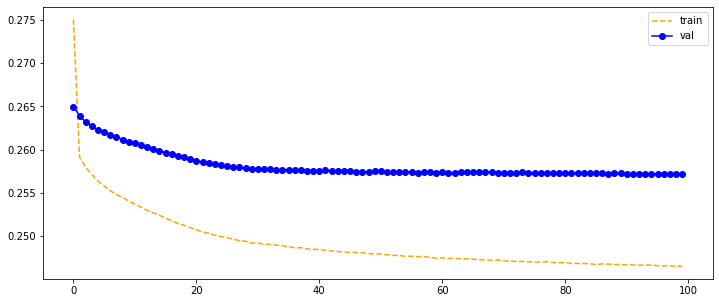

In [19]:
plot_loss(clf.train_loss, clf.val_loss)

In [20]:
net1 = FeedForward(len(X_train[0]), 50)

params = {
    'dataset': MyDataset,
    'net': net1,
    'batch_size': 1000,
    'epoch_amount': 100, 
    'learning_rate': 1e-2,
    'early_stopping': 10,
    'loss_f': RMSELoss(),
    'optim': torch.optim.Adam,
}

clf1 = Trainer(**params)
clf1.fit(X_train, X_test, y_train, y_test)

Эпоха: 0 Loss_train: 0.24783998445099129, 0:00:08.000277 сек
Loss_val: 0.25722387433052063

Эпоха: 1 Loss_train: 0.24464482086188827, 0:00:07.959065 сек
Loss_val: 0.2565986216068268

Эпоха: 2 Loss_train: 0.24444818766193188, 0:00:07.945650 сек
Loss_val: 0.25553709268569946

Эпоха: 3 Loss_train: 0.24434421959181205, 0:00:07.872455 сек
Loss_val: 0.2562776505947113

Эпоха: 4 Loss_train: 0.24418513355314309, 0:00:07.830834 сек
Loss_val: 0.2561401128768921

Эпоха: 5 Loss_train: 0.24423550654546167, 0:00:07.779295 сек
Loss_val: 0.2557821571826935

Эпоха: 6 Loss_train: 0.24419286183960048, 0:00:07.702469 сек
Loss_val: 0.25559476017951965

Эпоха: 7 Loss_train: 0.2442000433934707, 0:00:07.782754 сек
Loss_val: 0.257074773311615

Эпоха: 8 Loss_train: 0.24411964292327562, 0:00:07.906958 сек
Loss_val: 0.2557973861694336

Эпоха: 9 Loss_train: 0.24419927534957728, 0:00:07.797598 сек
Loss_val: 0.25540289282798767

Эпоха: 10 Loss_train: 0.2441075076051849, 0:00:07.780050 сек
Loss_val: 0.256137579679489

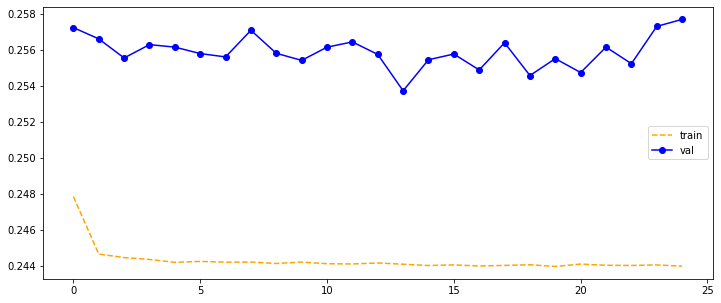

In [21]:
plot_loss(clf1.train_loss, clf1.val_loss)

In [25]:
net2 = FeedForward(len(X_train[0]), 50)

params = {
    'dataset': MyDataset,
    'net': net2,
    'batch_size': 1000,
    'epoch_amount': 100, 
    'learning_rate': 1e-2,
    'early_stopping': 10,
    'loss_f': RMSELoss(),
    'optim': torch.optim.RMSprop,
}

clf2 = Trainer(**params)
clf2.fit(X_train, X_test, y_train, y_test)

Эпоха: 0 Loss_train: 0.24646856135140496, 0:00:07.930041 сек
Loss_val: 0.2566535174846649

Эпоха: 1 Loss_train: 0.24428976415689532, 0:00:07.692041 сек
Loss_val: 0.25684115290641785

Эпоха: 2 Loss_train: 0.24411259835969049, 0:00:07.781041 сек
Loss_val: 0.2561280429363251

Эпоха: 3 Loss_train: 0.24395221915650875, 0:00:08.104942 сек
Loss_val: 0.25685980916023254

Эпоха: 4 Loss_train: 0.24372562870436104, 0:00:08.004519 сек
Loss_val: 0.25797727704048157

Эпоха: 5 Loss_train: 0.24367234471472018, 0:00:07.817548 сек
Loss_val: 0.2542656660079956

Эпоха: 6 Loss_train: 0.24363416434655374, 0:00:08.010042 сек
Loss_val: 0.2551993131637573

Эпоха: 7 Loss_train: 0.2436269039010748, 0:00:07.942996 сек
Loss_val: 0.25389814376831055

Эпоха: 8 Loss_train: 0.2433700758884562, 0:00:07.844009 сек
Loss_val: 0.2563593089580536

Эпоха: 9 Loss_train: 0.2433931189622228, 0:00:07.959450 сек
Loss_val: 0.2554163634777069

Эпоха: 10 Loss_train: 0.24333132272388072, 0:00:07.970254 сек
Loss_val: 0.257855951786041

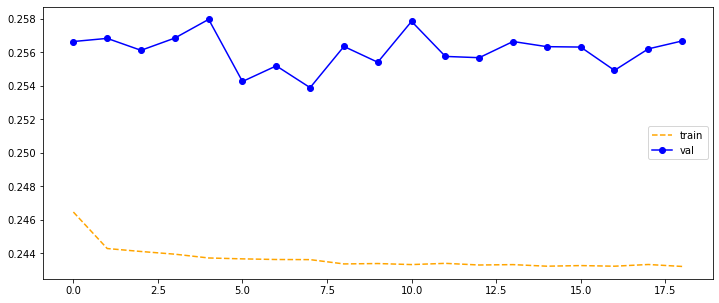

In [26]:
plot_loss(clf2.train_loss, clf2.val_loss)

__ВЫВОД:__ Оптимизаторы Adam и RMSprop показывают сравнительно равную эффективность. Для Adam на 13 эпохе получено лучшее значение метрики на валидационных данных, для RMSprop на 7. На результаты также может влиять фактор начальной инициализации весов моделей, поэтому сравнение корректнее проводить по усреднённым результатам, полученным в нескольких итерациях инициализации-обучения моделей.